# Expression Classification Model Training with PyTorch

This notebook demonstrates how to train a custom expression classification model using PyTorch, with CUDA support for GPU acceleration. The model will classify facial expressions into 7 categories: angry, disgust, fear, happy, neutral, sad, and surprise.

In [ ]:
!pip install Seaborn Scikit-learn NumPy Matplotlib torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
from PIL import Image

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.2.1


## Data Preparation and Normalization

In [18]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

data_dir = './face-expression-recognition-dataset/images/images'
img_height, img_width = 48, 48
batch_size = 150
num_classes = 7

# Define transforms
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((img_height, img_width)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform=test_transform)

# Split train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of classes: {num_classes}")
print(f"Class indices: {train_dataset.dataset.class_to_idx}")

# Compute class weights
targets = torch.tensor(train_dataset.dataset.targets)  # Convert targets to tensor
class_counts = torch.bincount(targets)  # Count occurrences of each class
total_samples = len(targets)
class_weights = torch.tensor([total_samples / (num_classes * count) for count in class_counts], dtype=torch.float32).to(device)
print("Class weights:", class_weights)


Number of training samples: 23056
Number of validation samples: 5765
Number of test samples: 7066
Number of classes: 7
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Class weights: tensor([1.0311, 9.4433, 1.0035, 0.5747, 0.8264, 0.8338, 1.2846],
       device='cuda:0')


## Model Definition

In [19]:
class ExpressionClassifier(nn.Module):
    def __init__(self):
        super(ExpressionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = ExpressionClassifier().to(device)
print(model)

ExpressionClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## Model Training

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'CUDA Available: {torch.cuda.is_available()}')
print(f'Device Name: {torch.cuda.get_device_name(0)}')
print(f'Device Count: {torch.cuda.device_count()}')

CUDA Available: True
Device Name: NVIDIA RTX 4000 Ada Generation
Device Count: 1


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)
        
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct.double() / len(train_loader.dataset)
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct.double() / len(val_loader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    print(f'Best val Acc: {best_val_acc:.4f}')

# Assuming model, class_weights, train_loader, and val_loader are defined
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Ensure model is on the correct device
model = model.to(device)

train_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/100
Train Loss: 1.9096 Acc: 0.1933
Val Loss: 1.8322 Acc: 0.2333
Epoch 2/100
Train Loss: 1.8372 Acc: 0.2414
Val Loss: 1.7895 Acc: 0.2635
Epoch 3/100
Train Loss: 1.8014 Acc: 0.2654
Val Loss: 1.7526 Acc: 0.3343
Epoch 4/100
Train Loss: 1.7517 Acc: 0.3197
Val Loss: 1.6790 Acc: 0.3611
Epoch 5/100
Train Loss: 1.7037 Acc: 0.3387
Val Loss: 1.6462 Acc: 0.3665
Epoch 6/100
Train Loss: 1.6547 Acc: 0.3717
Val Loss: 1.5533 Acc: 0.4212
Epoch 7/100
Train Loss: 1.6221 Acc: 0.3746
Val Loss: 1.5222 Acc: 0.4389
Epoch 8/100
Train Loss: 1.5851 Acc: 0.3883
Val Loss: 1.5014 Acc: 0.4461
Epoch 9/100
Train Loss: 1.5555 Acc: 0.4023
Val Loss: 1.4835 Acc: 0.4101
Epoch 10/100
Train Loss: 1.5244 Acc: 0.4082
Val Loss: 1.4706 Acc: 0.4316
Epoch 11/100
Train Loss: 1.5232 Acc: 0.4142
Val Loss: 1.4383 Acc: 0.4413
Epoch 12/100
Train Loss: 1.5090 Acc: 0.4207
Val Loss: 1.4457 Acc: 0.4356
Epoch 13/100
Train Loss: 1.4885 Acc: 0.4203
Val Loss: 1.4151 Acc: 0.4576
Epoch 14/100
Train Loss: 1.4815 Acc: 0.4228
Val Loss: 1.4006

## Model Evaluation

Test Accuracy: 0.5592


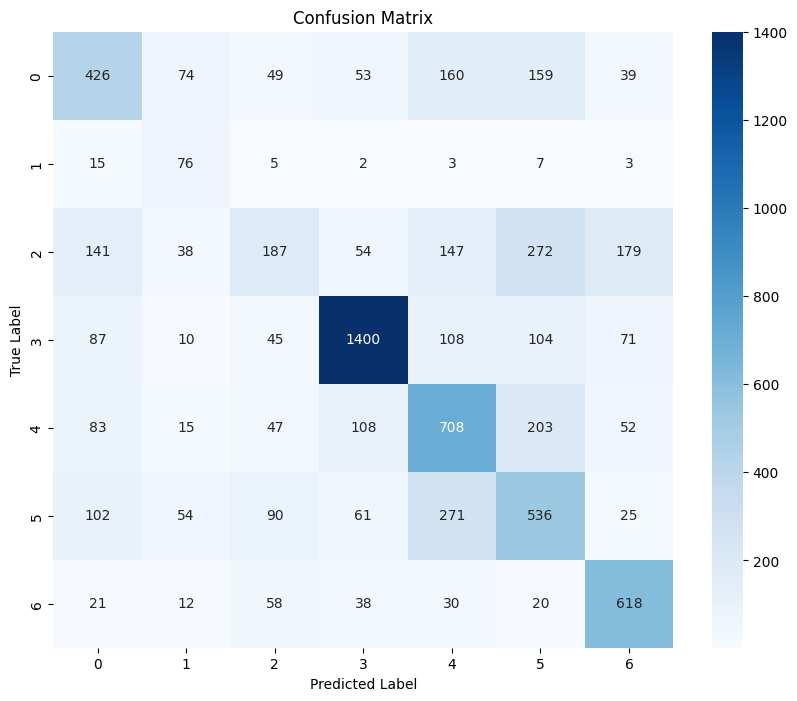

              precision    recall  f1-score   support

       angry       0.49      0.44      0.46       960
     disgust       0.27      0.68      0.39       111
        fear       0.39      0.18      0.25      1018
       happy       0.82      0.77      0.79      1825
     neutral       0.50      0.58      0.54      1216
         sad       0.41      0.47      0.44      1139
    surprise       0.63      0.78      0.69       797

    accuracy                           0.56      7066
   macro avg       0.50      0.56      0.51      7066
weighted avg       0.56      0.56      0.55      7066



In [39]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_correct = 0
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels.data)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_acc = test_correct.double() / len(test_loader.dataset)
print(f'Test Accuracy: {test_acc:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=list(train_dataset.dataset.class_to_idx.keys())))

## Try Out the Model

Chosen image path: ./face-expression-recognition-dataset/images/images/validation/angry/25844.jpg


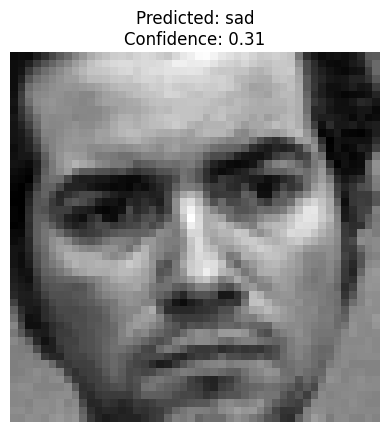

Probabilities for each class:
angry: 0.2479
disgust: 0.0012
fear: 0.1875
happy: 0.0093
neutral: 0.2356
sad: 0.3080
surprise: 0.0106


In [51]:
import random
def predict_expression(img_path, model):
    model.eval()
    img = Image.open(img_path).convert('L')
    img = test_transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        _, predicted_idx = torch.max(output, 1)
    
    class_names = list(train_dataset.dataset.class_to_idx.keys())
    predicted_class = class_names[predicted_idx.item()]
    confidence = probabilities[0][predicted_idx.item()].item()
    
    plt.imshow(Image.open(img_path).convert('L'), cmap='gray')
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
    plt.show()
    
    print("Probabilities for each class:")
    for class_name, prob in zip(class_names, probabilities[0]):
        print(f"{class_name}: {prob:.4f}")

# Example usage:
def get_random_image_path(base_dir):
    # Get all subdirectories (categories)
    categories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    # Choose a random category
    random_category = random.choice(categories)
    
    # Get all image files in the chosen category
    category_path = os.path.join(base_dir, random_category)
    image_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
    
    # Choose a random image file
    random_image = random.choice(image_files)
    
    return os.path.join(category_path, random_image)
# Directory containing the images
base_dir = './face-expression-recognition-dataset/images/images/validation/'
# Choose a random image
random_image_path = get_random_image_path(base_dir)
# Print the path of the chosen image
print(f"Chosen image path: {random_image_path}")

predict_expression(random_image_path, model)

## Save the Model

In [61]:
torch.save(model.state_dict(), 'expression_classification_model.pth')
print("Model saved as 'expression_classification_model.pth'")

Model saved as 'expression_classification_model.pth'


#### Check Saved State Dict Keys

In [62]:
# Load the state dictionary
state_dict = torch.load('expression_classification_model.pth')

# Print out the keys in the saved state dictionary
print("Keys in saved state_dict:")
for key in state_dict.keys():
    print(key)

# Print out the keys in the current model's state dictionary
print("\nKeys in current model state_dict:")
for key in loaded_model.state_dict().keys():
    print(key)

Keys in saved state_dict:
conv1.weight
conv1.bias
conv2.weight
conv2.bias
conv3.weight
conv3.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias

Keys in current model state_dict:


In [56]:
# Load and use the saved model
loaded_model = ExpressionClassifier().to(device)
loaded_model.load_state_dict(torch.load('expression_classification_model.pth'))
loaded_model.eval()

print("Loaded model:", loaded_model)

# Define image transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Adjust size as required by your model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Use appropriate mean and std
])

def get_random_image_path(base_dir):
    # Get all subdirectories (categories)
    categories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    # Choose a random category
    random_category = random.choice(categories)
    
    # Get all image files in the chosen category
    category_path = os.path.join(base_dir, random_category)
    image_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
    
    # Choose a random image file
    random_image = random.choice(image_files)
    
    return os.path.join(category_path, random_image)

def predict_expression(image_path, model):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Make prediction
    with torch.no_grad():
        output = model(image)
    
    # Get the predicted class
    _, predicted = torch.max(output, 1)
    
    print(f"Predicted class: {predicted.item()}")

# Directory containing the images
base_dir = './face-expression-recognition-dataset/images/images/validation/'
# Choose a random image
random_image_path = get_random_image_path(base_dir)
# Print the path of the chosen image
print(f"Chosen image path: {random_image_path}")

# Predict the expression
predict_expression(random_image_path, loaded_model)


RuntimeError: Error(s) in loading state_dict for ExpressionClassifier:
	Unexpected key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "conv3.weight", "conv3.bias", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 

## Visualize Some Training Images

Visualizing a batch of training images:


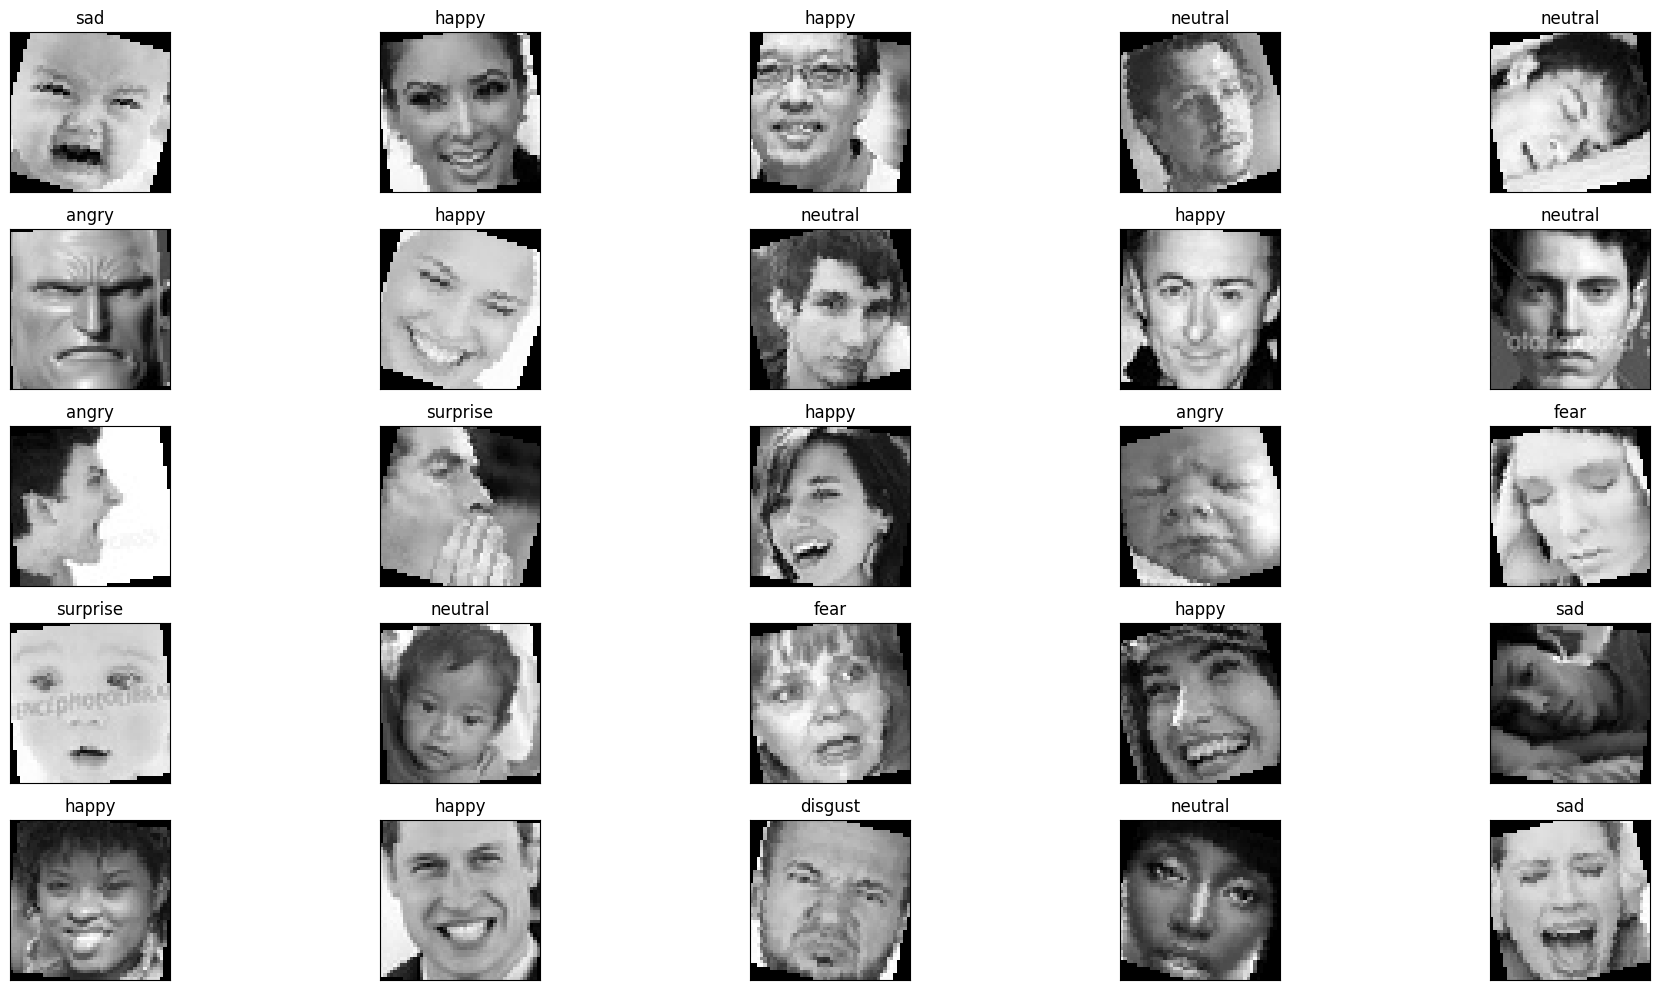

In [44]:
def show_batch(dataloader):
    images, labels = next(iter(dataloader))
    images = images.numpy()
    
    fig = plt.figure(figsize=(20, 10))
    for i in range(25):
        ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[i]), cmap='gray')
        ax.set_title(f"{list(train_dataset.dataset.class_to_idx.keys())[labels[i]]}")
    plt.tight_layout()
    plt.show()

print("Visualizing a batch of training images:")
show_batch(train_loader)

## Model Performance Visualization

In [45]:
def plot_performance(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.plot(history['train_loss'], label='train loss')
    ax1.plot(history['val_loss'], label='validation loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history['train_acc'], label='train accuracy')
    ax2.plot(history['val_acc'], label='validation accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

# Assuming you've stored the history during training
# plot_performance(history)

## Misclassified Images Analysis

Visualizing misclassified images:


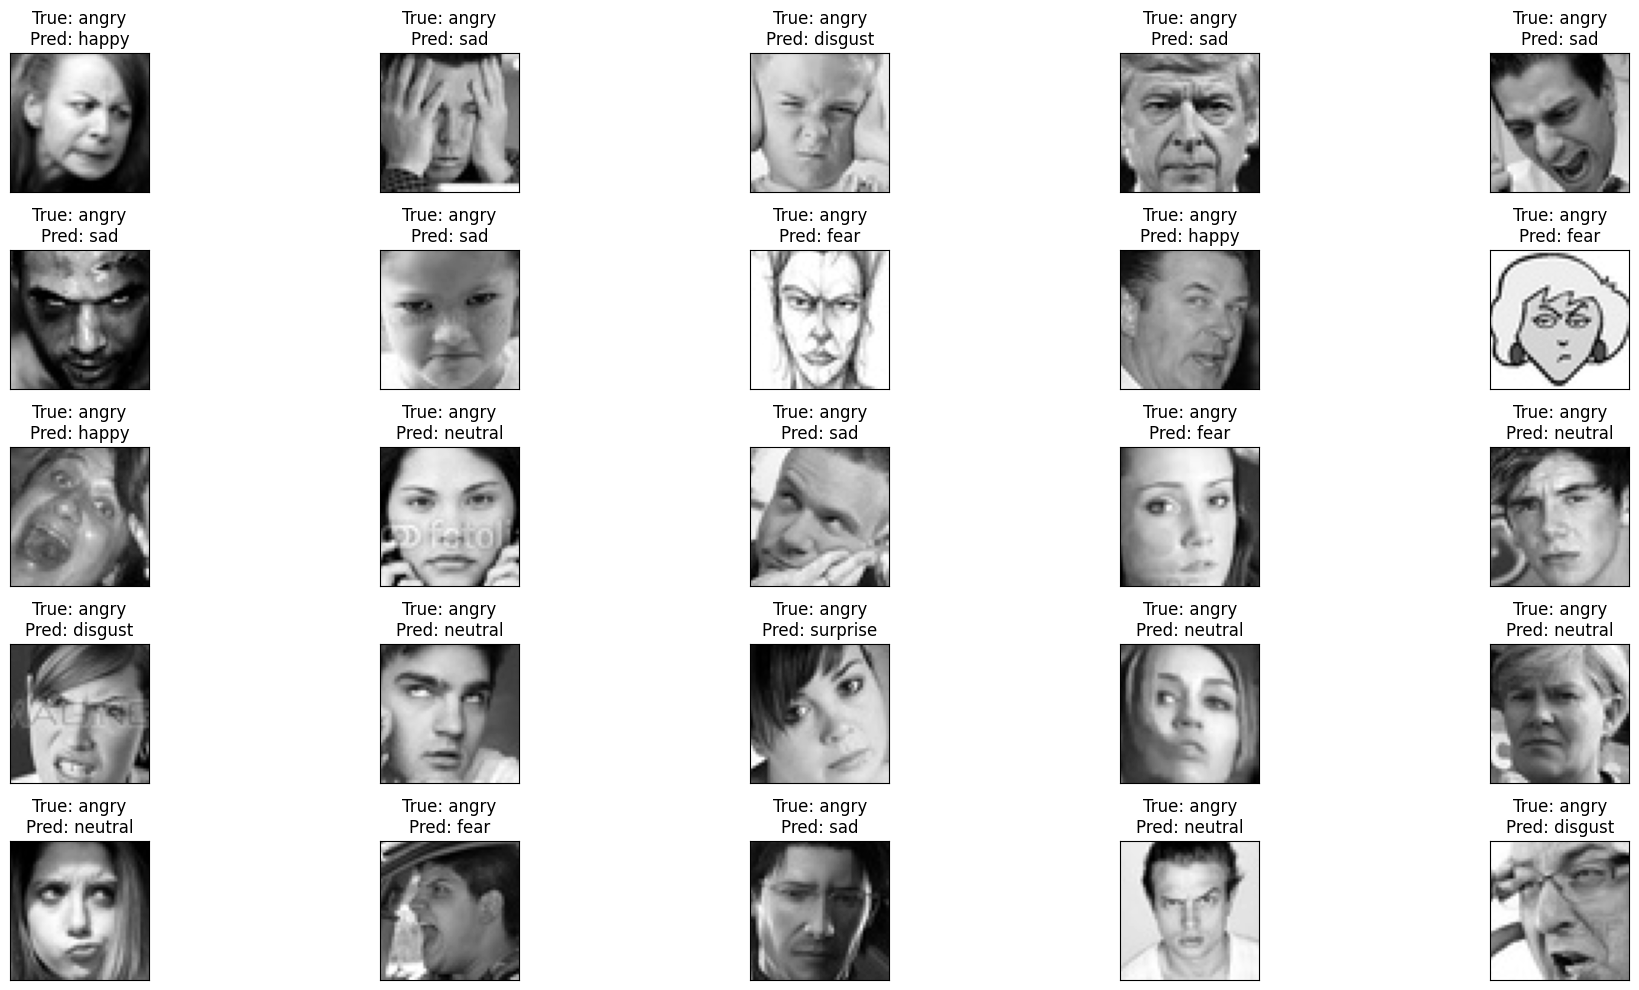

In [46]:
def show_misclassified(model, test_loader, num_images=25):
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            for i in range(len(preds)):
                if preds[i] != labels[i]:
                    misclassified_images.append(images[i].cpu())
                    misclassified_labels.append(labels[i].cpu())
                    misclassified_preds.append(preds[i].cpu())
                    
                    if len(misclassified_images) == num_images:
                        break
            
            if len(misclassified_images) == num_images:
                break
    
    fig = plt.figure(figsize=(20, 10))
    for i in range(num_images):
        ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(misclassified_images[i]), cmap='gray')
        ax.set_title(f"True: {list(train_dataset.dataset.class_to_idx.keys())[misclassified_labels[i]]}\nPred: {list(train_dataset.dataset.class_to_idx.keys())[misclassified_preds[i]]}")
    plt.tight_layout()
    plt.show()

print("Visualizing misclassified images:")
show_misclassified(model, test_loader)